**Problem Description and Data:**

The "Histopathologic Cancer Detection" competition provides images taken from larger digital pathology scans. Each image is 96px by 96px. The goal is to use a CNN algorithm that will detect at least a single cell of tumor tissue, which is in the center 32px x 32px region of the original image.

In this notebook, we compare two CNN's using a different optimizer and tweaking the hyperparameters of each model.

In [1]:
# Importing  Libraries
from numpy.random import seed
seed = seed(75)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings('ignore')

2024-06-04 01:14:33.795443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 01:14:33.795491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 01:14:33.796926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Delete the test_dir and the train_val_dir if running the session
shutil.rmtree('test_dir')
shutil.rmtree('train_val_dir')
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
# number of data points in train and test datasets
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [4]:
# Creating a dataframe of all the training images
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df_data.shape)

(220025, 2)


In [5]:
df_data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

**EDA:**

The training dataset consists of 220,025 data points. The 59.5% of data labeled as benign and 40.5% of data is cancerous (Pulled from pie chart below). The test data set contains 57,458 data points.

We need to equalize the number of data points in the trainining dataset, so 89,110 images labeled as benign (0) and 89,110 images lebeled as cancerous (1) are picked randomly from the original training dataset.

We split the new trainining dataset into a 10% validation and 90% training sets. The validation set has same 80,199 images for benign and cancerous images.

The datasets that kaggle maintains does not need any cleaning for duplicate images as stated in the competition text. If we were working with the original PCAM dataset, this would be the first thing we would need to do.

In [6]:
def plot_figures(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols)
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
    plt.tight_layout()
    plt.show()

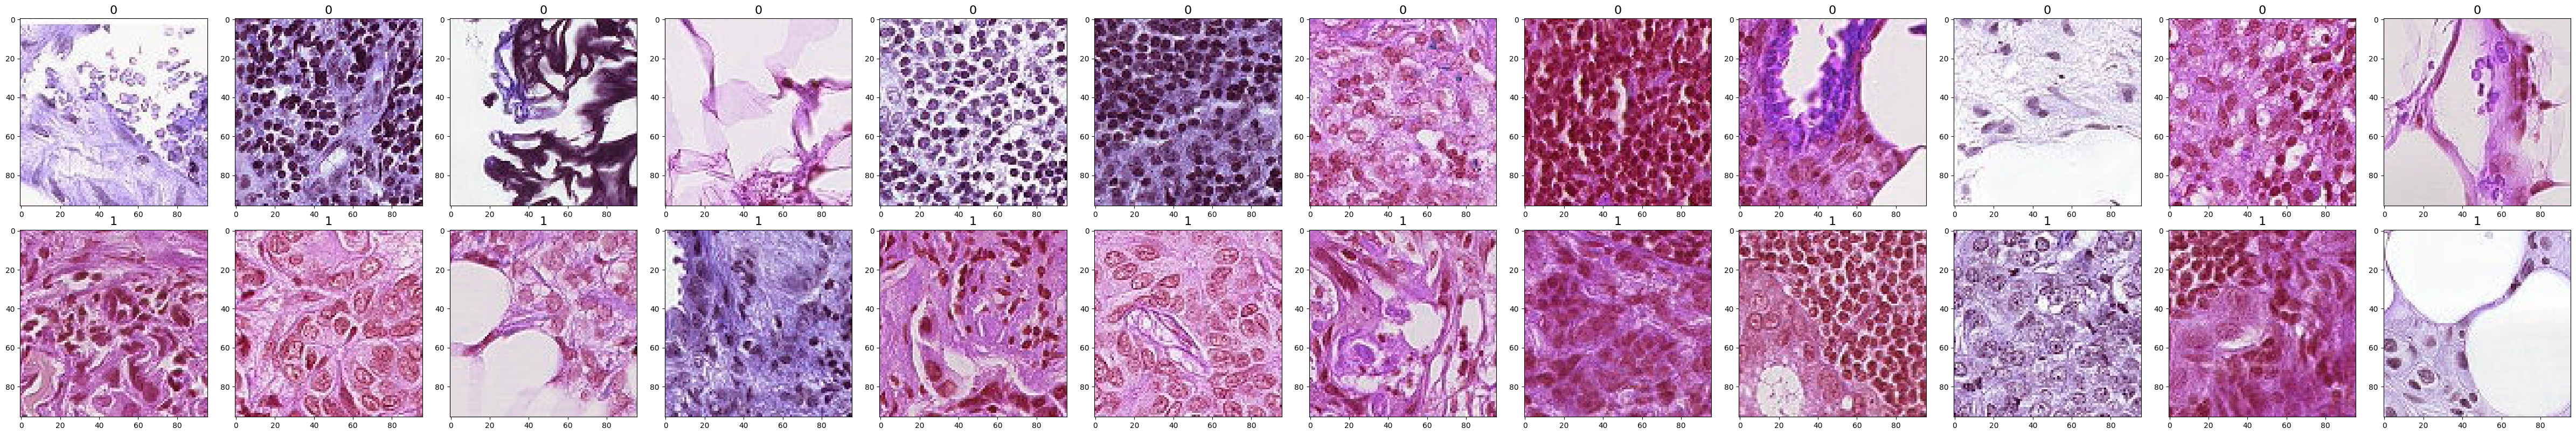

In [7]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/'

plot_figures('label',12, df_data, IMAGE_PATH)

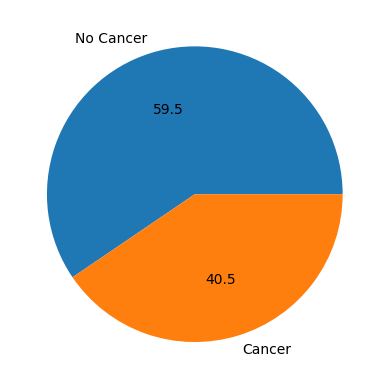

In [8]:
plt.pie(df_data.label.value_counts(), labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.show()

In [9]:
# Create the Train and Validation Sets
#From the above, our sample set can not be anything over the 40.5% so we can set our sample size here
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE = 89110
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

label
1    89110
0    89110
Name: count, dtype: int64

In [10]:
#train-test split
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(160398, 2)
(17822, 2)


In [11]:
# Create a new directory for splitting out our training and validation images 
train_val_dir='train_val_dir'
os.mkdir(train_val_dir)

#In each directory we should create another set of folders for splitting out images with tumors and without

train_dir = os.path.join(train_val_dir, 'train_dir')
os.mkdir(train_dir)
validation_dir = os.path.join(train_val_dir, 'validation_dir')
os.mkdir(validation_dir)

no_tumor_tissue = os.path.join(train_dir, 'no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'has_tumor_tissue')
os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(validation_dir, 'no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(validation_dir, 'has_tumor_tissue')
os.mkdir(has_tumor_tissue)

#We will also create our directory with our test images
test_dir = 'test_dir'
os.mkdir(test_dir)

# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)


In [12]:
# Set the id as the index
df_data.set_index('id', inplace=True)

In [13]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

def transfer_image(source_path, destination_path, image_list):
    for image in image_list:

        fname = image + '.tif'
        target = df_data.loc[image,'label']
        if target == 0:
            label = 'no_tumor_tissue'
        if target == 1:
            label = 'has_tumor_tissue'

        # source path
        src = os.path.join(source_path, fname)
        # destination path
        dst = os.path.join(destination_path, label, fname)
        # copy from the source to the destination
        shutil.copyfile(src, dst)


train_val_src_path = '../input/histopathologic-cancer-detection/train'
transfer_image(train_val_src_path, train_dir, train_list)
transfer_image(train_val_src_path, validation_dir, val_list)

In [14]:
# Set up the generators
train_path = 'train_val_dir/train_dir'
valid_path = 'train_val_dir/validation_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 100
val_batch_size = 100
print(num_train_samples)
print(num_val_samples)

train_steps = num_train_samples / train_batch_size
val_steps = num_val_samples / val_batch_size

print(train_steps)
print(val_steps)

160398
17822
1603.98
178.22


In [15]:
datagen = ImageDataGenerator(rescale=1.0/255)

def generator(path, batch_size, shuffle=True):
    return datagen.flow_from_directory(path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=shuffle)

train_gen = generator(train_path, train_batch_size)
validation_gen = generator(valid_path, val_batch_size)
test_gen = generator(valid_path, 1, shuffle=False)

Found 160398 images belonging to 2 classes.
Found 17822 images belonging to 2 classes.
Found 17822 images belonging to 2 classes.


**Model Architecture:**

The model below is a simple convolutional neural network built in Keras Sequential. There are 3 layers of a convolution, a pooling layer,and a dropout layer (to prevent overfitting), and a flatten layer followed by 2 dense layers of neurons with final activation of a softmax function. For the learning rate, I have it set to .001 and I am using the adam optimizer. To read more about adam, see: https://builtin.com/machine-learning/adam-optimization

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,818 (12.86 MB)

 Trainable params: 3,370,818 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

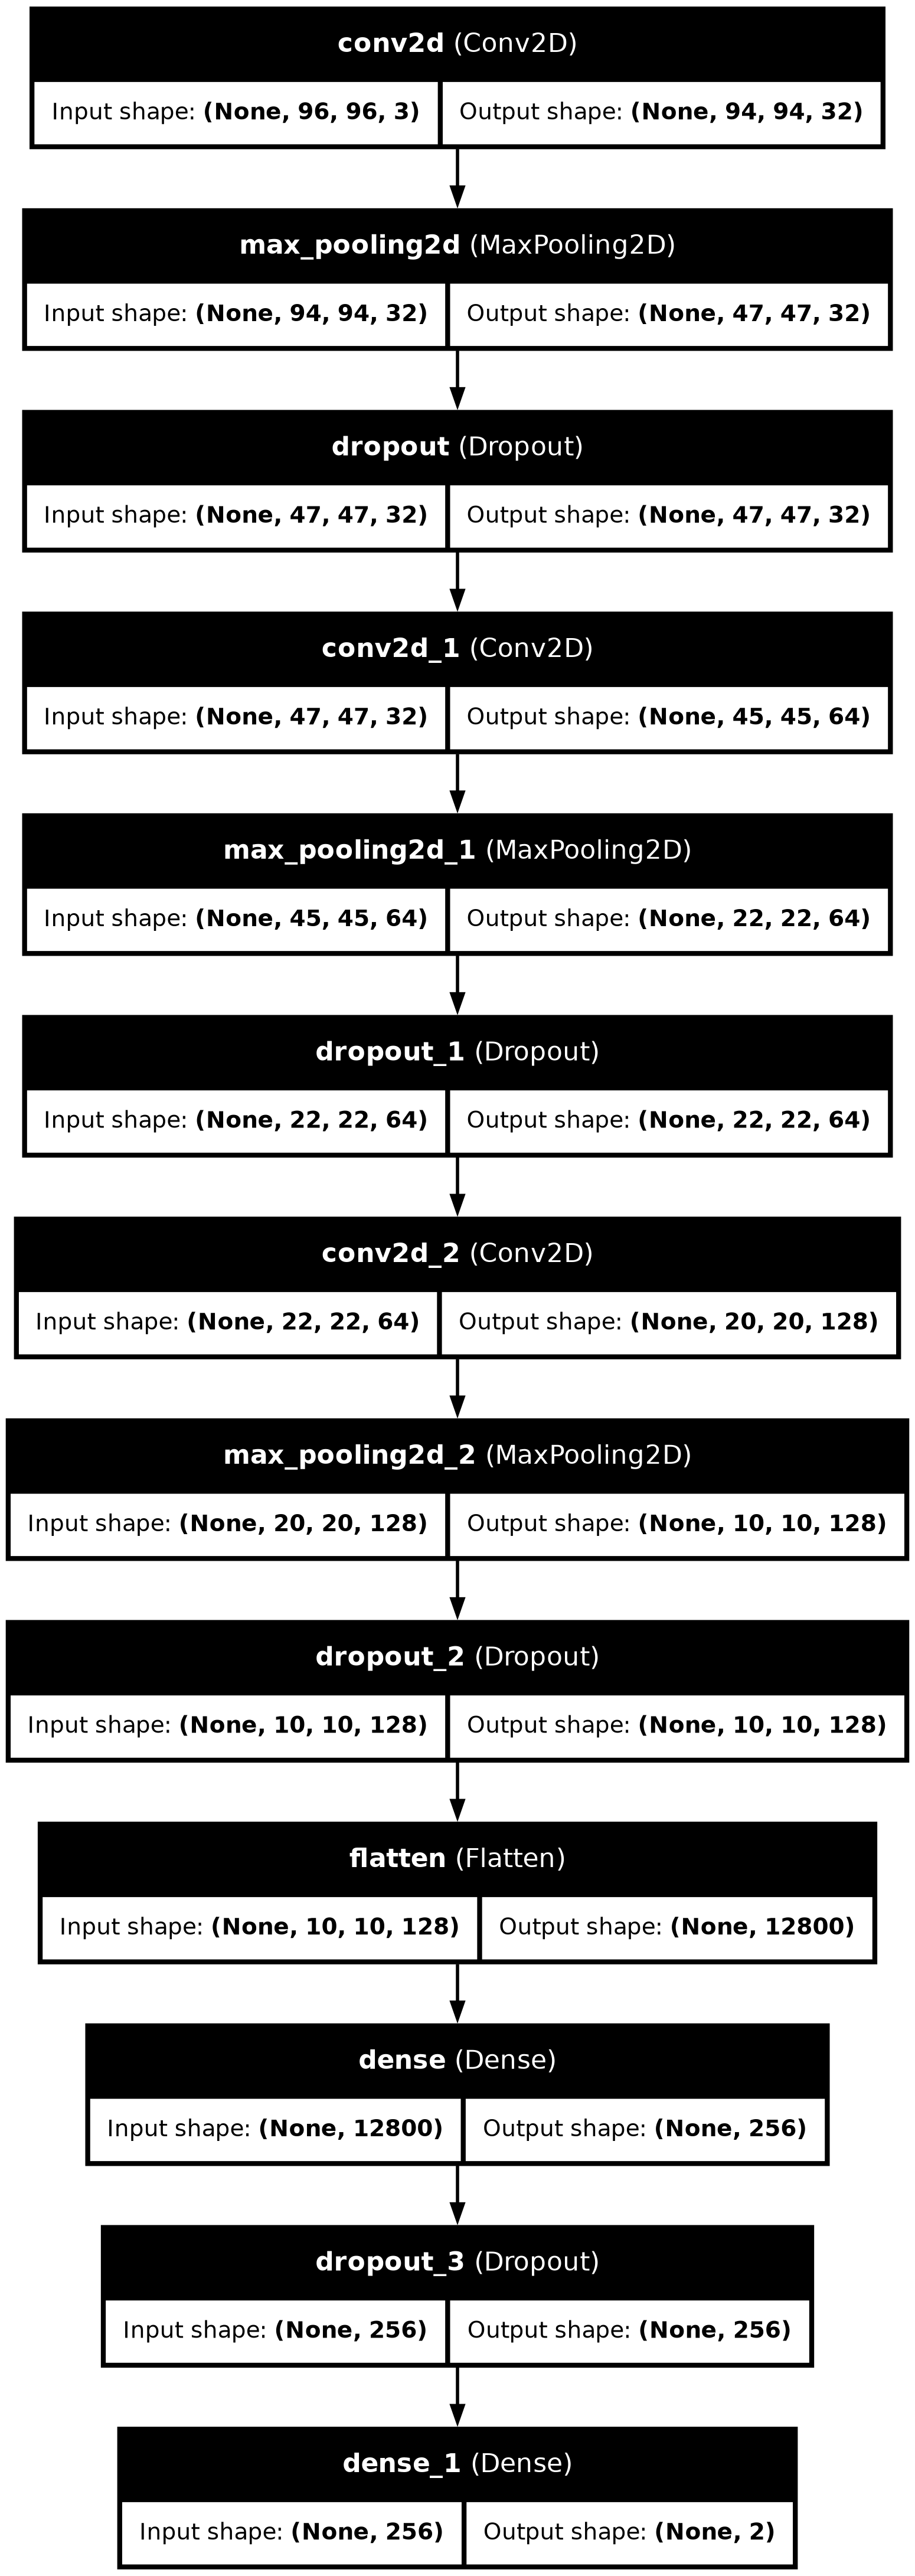

In [16]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.2
dropout_dense = 0.2


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=int(train_steps),
                    validation_data=validation_gen,
                    validation_steps=int(val_steps),
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10


2024-06-04 01:19:23.913190: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17788: 4.85724, expected 4.26016
2024-06-04 01:19:23.913243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17922: 4.89742, expected 4.30033
2024-06-04 01:19:23.913253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17981: 4.8524, expected 4.25531
2024-06-04 01:19:23.913261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18188: 4.89874, expected 4.30165
2024-06-04 01:19:23.913269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18189: 4.94869, expected 4.3516
2024-06-04 01:19:23.913277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18258: 4.96743, expected 4.37035
2024-06-04 01:19:23.913284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18262: 4.73195, expected 4.13487
2024-06-04 01:19:23.913292: E

   3/1603 ━━━━━━━━━━━━━━━━━━━━ 1:33 59ms/step - accuracy: 0.4989 - loss: 0.8738  

I0000 00:00:1717463969.523610    1521 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717463969.538638    1521 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 528/1603 ━━━━━━━━━━━━━━━━━━━━ 1:35 89ms/step - accuracy: 0.6932 - loss: 0.5836

2024-06-04 01:20:19.175768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17733: 7.50833, expected 6.65183
2024-06-04 01:20:19.175837: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17734: 6.82962, expected 5.97312
2024-06-04 01:20:19.175854: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17735: 6.39838, expected 5.54188
2024-06-04 01:20:19.175872: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17736: 7.462, expected 6.6055
2024-06-04 01:20:19.175886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17745: 6.23615, expected 5.37965
2024-06-04 01:20:19.175897: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17755: 7.46689, expected 6.61039
2024-06-04 01:20:19.175908: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17756: 6.59453, expected 5.73803
2024-06-04 01:20:19.175920: E 

 532/1603 ━━━━━━━━━━━━━━━━━━━━ 1:50 104ms/step - accuracy: 0.6936 - loss: 0.5831

W0000 00:00:1717464024.456304    1522 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7440 - loss: 0.5211

W0000 00:00:1717464119.560195    1519 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1603/1603 ━━━━━━━━━━━━━━━━━━━━ 176s 103ms/step - accuracy: 0.7440 - loss: 0.5211 - val_accuracy: 0.7847 - val_loss: 0.5027 - learning_rate: 0.0010
Epoch 2/10
   1/1603 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.7300 - loss: 0.5462

2024-06-04 01:22:14.109664: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61: 6.57478, expected 5.81659
2024-06-04 01:22:14.109728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 6.46929, expected 5.71109
2024-06-04 01:22:14.109737: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 6.16869, expected 5.41049
2024-06-04 01:22:14.109745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 6.39262, expected 5.63442
2024-06-04 01:22:14.109753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 6.50264, expected 5.74445
2024-06-04 01:22:14.109760: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 116: 6.42814, expected 5.66995
2024-06-04 01:22:14.109768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 145: 6.27946, expected 5.52126
2024-06-04 01:22:14.109776: E external/local_x

1603/1603 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.7300 - loss: 0.5462 - val_accuracy: 0.7273 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 3/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 156s 97ms/step - accuracy: 0.8099 - loss: 0.4265 - val_accuracy: 0.8275 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 4/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8600 - loss: 0.3182 - val_accuracy: 0.8182 - val_loss: 0.4551 - learning_rate: 0.0010
Epoch 5/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 156s 97ms/step - accuracy: 0.8369 - loss: 0.3776 - val_accuracy: 0.8496 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 6/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - accuracy: 0.8500 - loss: 0.3689 - val_accuracy: 0.8636 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 7/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 153s 95ms/step - accuracy: 0.8511 - loss: 0.3484 - val_accuracy: 0.8524 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 8/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8200 

In [21]:
def validation_loss_accuracy(generator, steps):
    val_loss, val_acc = model.evaluate(generator,
                                       steps=steps)

    return val_loss, val_acc

In [22]:
val_loss, val_acc = validation_loss_accuracy(test_gen, len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

17822/17822 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.8415 - loss: 0.3543
val_loss: 0.36878249049186707
val_acc: 0.8545056581497192


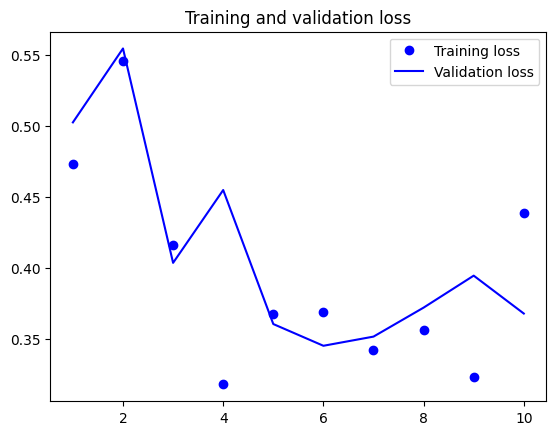

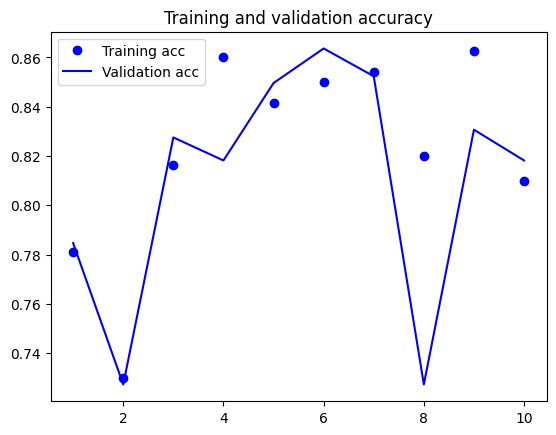

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt


def plot_loss_accuracy(fit_model):
    acc = fit_model.history['accuracy']
    val_acc = fit_model.history['val_accuracy']
    loss = fit_model.history['loss']
    val_loss = fit_model.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

# display the loss and accuracy curves
plot_loss_accuracy(history)

In [24]:
# make a prediction
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

17822/17822 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


In [25]:
# Put the predictions into a dataframe.
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.388957,0.611043
1,0.999991,0.000009
2,0.999182,0.000818
3,0.993021,0.006979
4,0.391275,0.608725


In [26]:
# Get the true labels and predicted labels
y_true = test_gen.classes
y_pred = df_preds['has_tumor_tissue']

In [27]:
roc_auc_score(y_true, y_pred)

0.9254544191987899

In [28]:
# Get the labels of the test images.
test_labels = test_gen.classes
test_labels.shape

(17822,)

In [29]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [30]:
#Need to setup the test images folder
test_src_path = '../input/histopathologic-cancer-detection/test'
test_list = os.listdir(test_src_path)
transfer_image(test_src_path, test_images, test_list)

In [31]:
test_path ='test_dir'
test_gen = generator(test_path, 1, shuffle=False)

Found 57458 images belonging to 1 classes.


In [32]:
num_test_images = 57458
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 140s 2ms/step


In [33]:
# Build the predictions dataframe
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.956657,0.043343
1,0.998477,0.001523
2,0.255103,0.744897
3,0.574720,0.425280
4,0.024646,0.975354


In [34]:
# This outputs the file names in the sequence in which
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.956657,0.043343,test_images/00006537328c33e284c973d7b39d340809...
1,0.998477,0.001523,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.255103,0.744897,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.574720,0.425280,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.024646,0.975354,test_images/000270442cc15af719583a8172c87cd2bd...


In [35]:
def get_id(x):
    filepath_sep = x.split('/')
    file_extension_sep = filepath_sep[1].split('.')
    get_id = file_extension_sep[0]

    return get_id

df_preds['id'] = df_preds['file_names'].apply(get_id)
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.956657,0.043343,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.998477,0.001523,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.255103,0.744897,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.574720,0.425280,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.024646,0.975354,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [36]:
#Predicted labels
y_pred = df_preds['has_tumor_tissue']
image_id = df_preds['id']


def generate_submission(image_id, y_pred, name):
    submission = pd.DataFrame({'id':image_id, 
                               'label':y_pred, 
                              }).set_index('id')

    submission.to_csv(name, columns=['label']) 
    submission.head()

generate_submission(image_id, y_pred, 'model1_submission.csv')


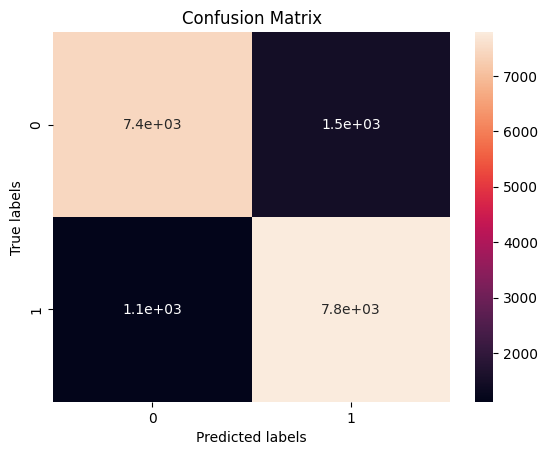

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');


**Results and Analysis**

Looking at the roc_auc_score (0.9254544191987899), we can say this is a very good score for our model. In this case, our model has to do with the identification of cancer cells so we would hope to aim for a score greater than or equal to 0.95. Aside from this, our model is fairly accurate. Looking at our confusion matrix yields not the greatest performance for this model as the false negative and false positive values would ideally be much lower. It should also be noted that from the accuracy plot, there is good generalization of the model; however, there is some jitter present which leads me to believe that there is some overfitting on our data from our model.

**Model Architecture:**

The model below is a simple convolutional neural network built in Keras Sequential. There are 3 layers of a convolution, a pooling layer,and a dropout layer (to prevent overfitting), and a flatten layer followed by 2 dense layers of neurons with final activation of a softmax function. Notice there is also a batch normalization layer now. This is to help with the learning speed and provides regularization which will help avoid overfitting further. For the learning rate, I have it set to .0001 and I am using the adamw optimizer which is a better improved version of the adam optimizer. To read more about adamw, see: https://towardsdatascience.com/why-adamw-matters-736223f31b5d

From this model, we hope to see a better fit overall.

In [38]:
test_gen = generator(valid_path, 1, shuffle=False)

Found 17822 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372,738 (12.87 MB)

 Trainable params: 3,371,778 (12.86 MB)

 Non-trainable params: 960 (3.75 KB)

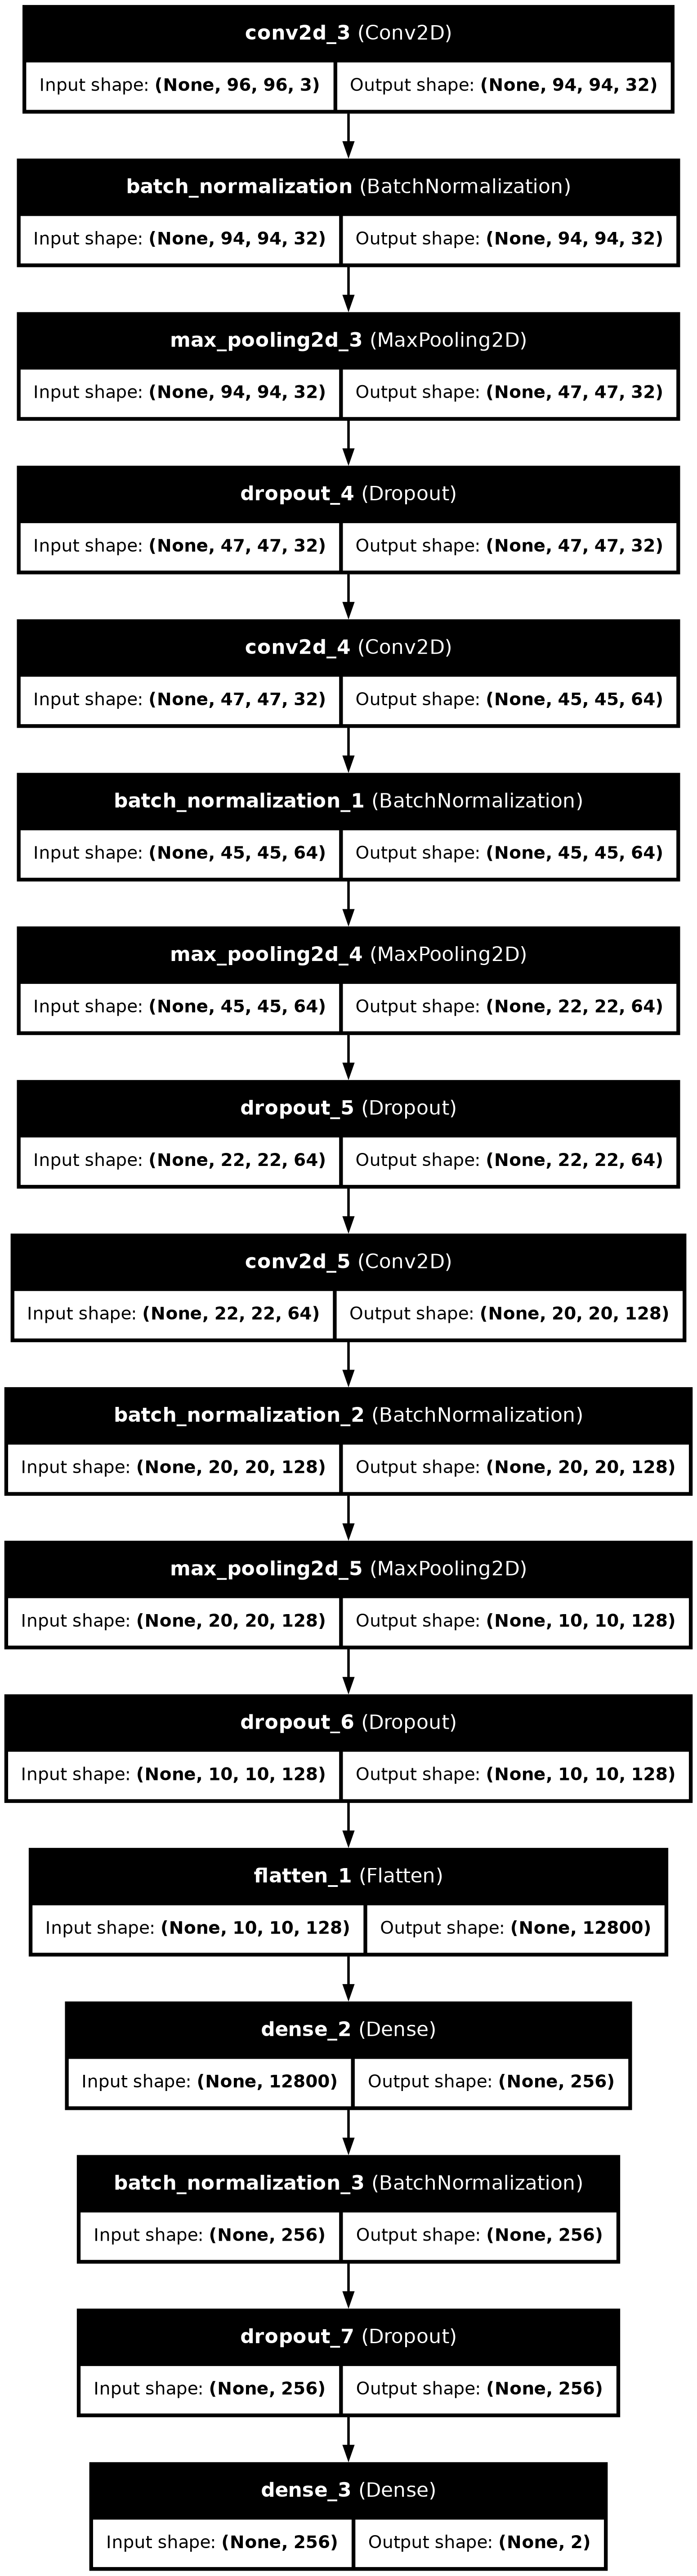

In [39]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

plot_model(model, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
from tensorflow.keras.optimizers import AdamW
model.compile(AdamW(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
filepath = "model2.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=int(train_steps),
                    validation_data=validation_gen,
                    validation_steps=int(val_steps),
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
   3/1603 ━━━━━━━━━━━━━━━━━━━━ 1:32 58ms/step - accuracy: 0.5839 - loss: 0.8628  

W0000 00:00:1717465266.182773    1521 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 751/1603 ━━━━━━━━━━━━━━━━━━━━ 1:21 96ms/step - accuracy: 0.7730 - loss: 0.5244

W0000 00:00:1717465338.135247    1521 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7879 - loss: 0.4879

W0000 00:00:1717465411.235944    1519 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1603/1603 ━━━━━━━━━━━━━━━━━━━━ 169s 99ms/step - accuracy: 0.7879 - loss: 0.4879 - val_accuracy: 0.7361 - val_loss: 1.0559 - learning_rate: 1.0000e-04
Epoch 2/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.8900 - loss: 0.3183 - val_accuracy: 0.6364 - val_loss: 1.1081 - learning_rate: 1.0000e-04
Epoch 3/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 155s 96ms/step - accuracy: 0.8348 - loss: 0.3827 - val_accuracy: 0.7734 - val_loss: 1.5614 - learning_rate: 1.0000e-04
Epoch 4/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.8900 - loss: 0.3353 - val_accuracy: 0.7727 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 5/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 155s 96ms/step - accuracy: 0.8511 - loss: 0.3482 - val_accuracy: 0.8145 - val_loss: 0.5868 - learning_rate: 1.0000e-04
Epoch 6/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8700 - loss: 0.3036 - val_accuracy: 0.8182 - val_loss: 0.5057 - learning_rate: 1.0000e-04
Epoch 7/10
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 157s 98m

In [42]:
model.metrics_names

['loss', 'compile_metrics']

In [43]:
val_loss, val_acc = validation_loss_accuracy(test_gen, len(df_val))
print('val_loss:', val_loss)
print('val_acc:', val_acc)

17822/17822 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.8505 - loss: 0.8945
val_loss: 0.7665369510650635
val_acc: 0.8426663875579834


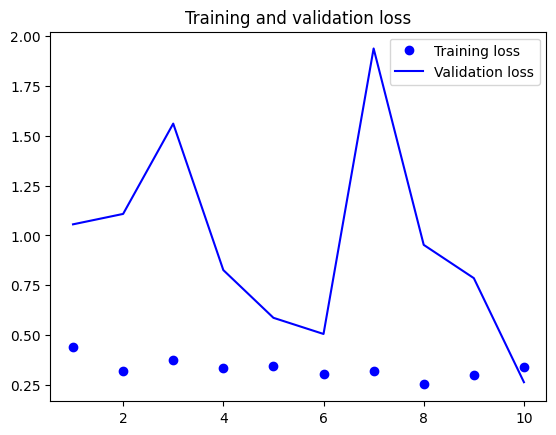

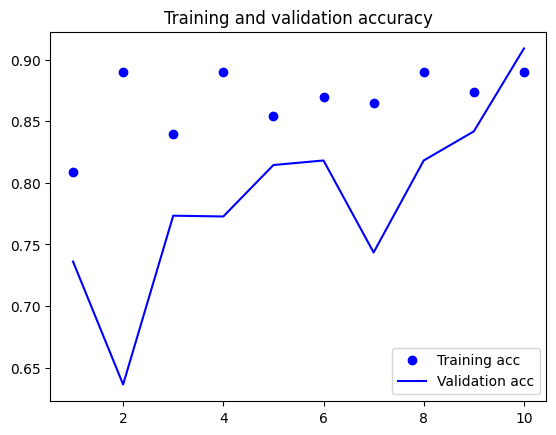

<Figure size 640x480 with 0 Axes>

In [44]:
plot_loss_accuracy(history)

In [45]:
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

17822/17822 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step


In [46]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.999955,4.535122e-05
1,0.999904,9.572157e-05
2,1.000000,1.359201e-14
3,0.999999,1.016773e-06
4,0.033737,9.662632e-01


In [47]:
y_true = test_gen.classes
y_pred = df_preds['has_tumor_tissue']

In [48]:
roc_auc_score(y_true, y_pred)

0.9069211539023644

In [49]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [50]:
test_path ='test_dir'
test_gen = generator(test_path, 1, shuffle=False)

Found 57458 images belonging to 1 classes.


In [51]:
num_test_images = 57458
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step


In [52]:
len(predictions)
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.999957,0.000043
1,0.999614,0.000386
2,0.750201,0.249799
3,0.996256,0.003744
4,0.001330,0.998670


In [53]:
test_filenames = test_gen.filenames
df_preds['file_names'] = test_filenames
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.999957,0.000043,test_images/00006537328c33e284c973d7b39d340809...
1,0.999614,0.000386,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.750201,0.249799,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.996256,0.003744,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.001330,0.998670,test_images/000270442cc15af719583a8172c87cd2bd...


In [54]:
df_preds['id'] = df_preds['file_names'].apply(get_id)
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.999957,0.000043,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.999614,0.000386,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.750201,0.249799,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.996256,0.003744,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.001330,0.998670,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [55]:
y_pred = df_preds['has_tumor_tissue']
image_id = df_preds['id']

generate_submission(image_id, y_pred, 'model2_submission.csv')

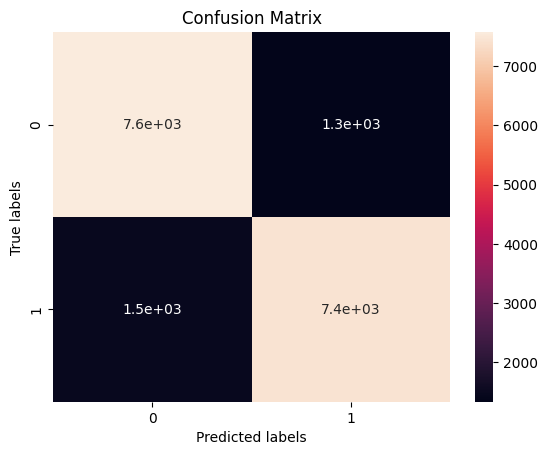

In [56]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');


**Results and Analysis**

Looking at the roc_auc_score (0.9069211539023644) versus the first model, this model is slightly worse. Looking at our confusion matrix yields a similar performance for this model as well. The accuracy and loss plots point to our model having bad generalization which could come down to the additional layers and tuning of our hyperparameters. At one point, the loss continues to grow pointing to a diverging model.


**Conclusion**

From the two models, it was noticed there was overfitting present. To fix this overfitting in the future we should try to apply early stopping, regularization techniques, or tune the hyperparameters further. From these two models, model 2 seemed to perform worse which could be due to the model having more layers than the first which increases model complexity. Another thing that we could try is to increase the training set size.

In the future, I would like to apply other optimizer to compare their performance to the models presented in this notebook.